In [14]:
import numpy as np
from matplotlib import pyplot as plt

from kalman_bucy import kalman_bucy

# Single Scale Lorenz 96

In [15]:
def lorenz96(x, F=8):
    N = len(x)
    dx = np.zeros(N)
    for k in range(N):
        dx[k] = (x[(k+1)%N] - x[k-2]) * x[k-1] - x[k] + F
    return dx


100%|██████████| 9999/9999 [00:00<00:00, 11087.87it/s]


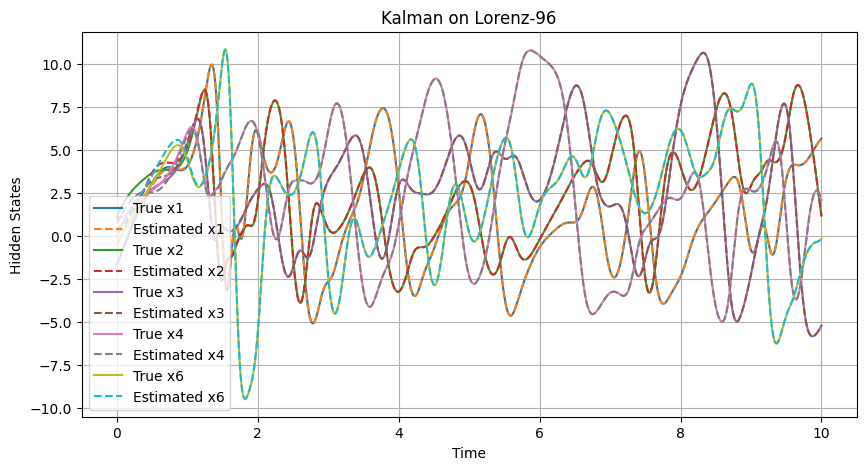

In [16]:
N = 7
F = 8
T = 10
n = 10000
x = np.random.randn(N)
dt = T / (n-1)
x_traj = np.zeros((n, N))
x_traj[0] = x
for i in range(1, n):
    # get true Lorenz-96 trajectory
    x_traj[i] = x_traj[i-1] + lorenz96(x_traj[i-1], F) * dt



obs_idx = [0,5]         # indices of observed variables
hid_idx = [i for i in range(N) if i not in obs_idx]  # hidden variables

uI = x[obs_idx]    
uII = x[hid_idx]  

def f_uI(t, uI, uII, obs_idx = obs_idx, hid_idx = hid_idx, F=8):
    """Derivative of observed variables, expressed as function of uII."""
    N = len(uI) + len(uII)
    x_full = np.zeros(N)
    x_full[obs_idx] = uI
    x_full[hid_idx] = uII
    dx_full = lorenz96(x_full, F)
    return dx_full[obs_idx]

def f_uII(t, uI, uII, obs_idx = obs_idx, hid_idx = hid_idx, F=8):
    """Derivative of hidden variables."""
    N = len(uI) + len(uII)
    x_full = np.zeros(N)
    x_full[obs_idx] = uI
    x_full[hid_idx] = uII
    dx_full = lorenz96(x_full, F)
    return dx_full[hid_idx]

t_span = (0, T)
uI = x.copy()
n = len(uI)
t =  np.linspace(t_span[0], t_span[1], n)

uI_traj = x_traj[:, obs_idx]
uII_0 = np.random.random((x_traj[0, hid_idx]).shape)

results = kalman_bucy(
    d_uI=lambda t,uI,uII: f_uI(t,uI,uII),
    d_uII=lambda t,uI,uII: f_uII(t,uI,uII),
    t_span=t_span,
    uI=uI_traj,
    uII_0=uII_0,
    R0=.5*np.eye(len(hid_idx)),
    SigmaI=0.1*np.eye(len(obs_idx)),
    SigmaII=0.01*np.eye(len(hid_idx)),
    dt=dt
)

# plot a few hidden variables
uII_est = results['uII']
t_vals = results['t']

plt.figure(figsize=(10,5))
for i in range(min(5, len(hid_idx))):
    plt.plot(t_vals, x_traj[:, hid_idx[i]], label=f'True x{hid_idx[i]}')
    plt.plot(t_vals, uII_est[i], '--', label=f'Estimated x{hid_idx[i]}')
plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.legend()
plt.title("Kalman on Lorenz-96")
plt.grid()
plt.show()



# Multiscale Lorenz 96
suppose all fast and some slow variables are hidden 

In [17]:
def lorenz96_multiscale(u, v, dt, hc, hv, eps, F = 8):
    N,J = v.shape
    du = np.zeros(N)
    for i in range(N):
        du[i] = (u[(i+1)%N] - u[i-2]) * u[i-1] - u[i] + F -(hc/J)*np.sum(v[i])
    dv = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
            dv[i,j] = (1/eps)*(hv*u[i] + v[i,(j+1)%J]*(v[i,j-1] - v[i,(j+2)%J]) - v[i,j])

    return u + dt*du, v + dt*dv


100%|██████████| 999/999 [00:47<00:00, 21.19it/s]


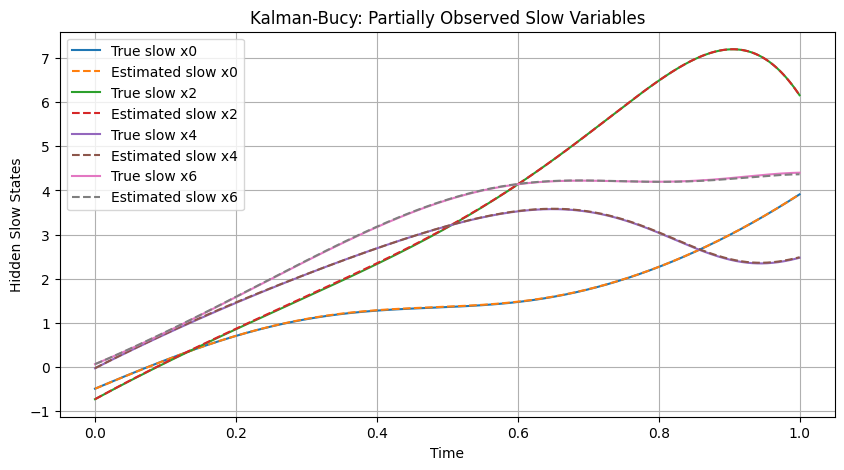

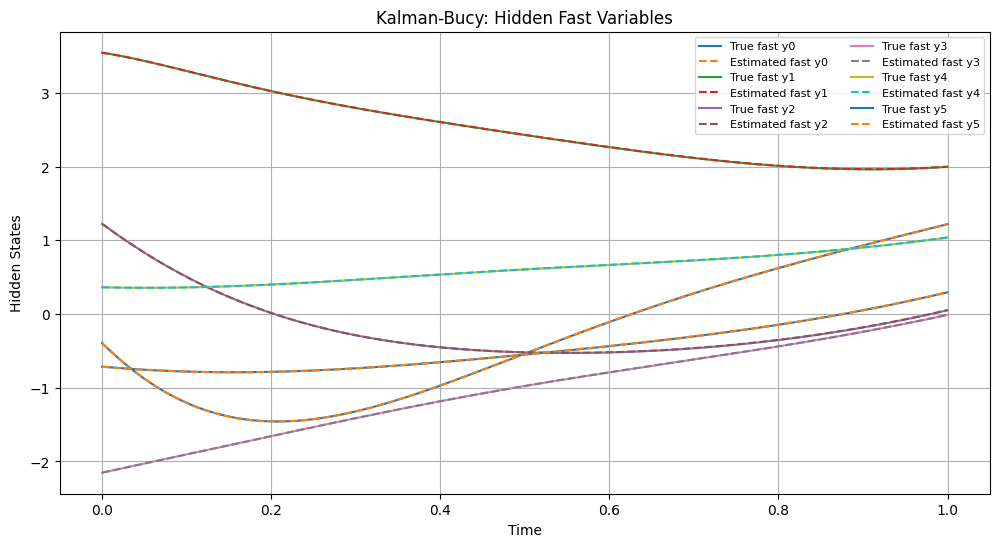

In [18]:
N = 8
J = 32
F = 8
T = 1
hc = .7
hv = .7
n = 1000
eps = 1
x = np.random.randn(N)  # initial condition
dt = T / (n-1)

# generate true system
X_true = np.random.randn(N)
Y_true = np.random.randn(N,J)
X_traj = np.zeros((n,N))
Y_traj = np.zeros((n,N,J))
X_traj[0] = X_true
Y_traj[0] = Y_true
for i in range(1,n):
    X_traj[i], Y_traj[i] = lorenz96_multiscale(X_traj[i-1], Y_traj[i-1],dt,hc,hv,eps,F)


unobs_id = np.arange(0,N,2)  # choose which slow variables to hide
obs_idx = np.setdiff1d(np.arange(N),unobs_id)  # other slow variables are observed
hid_idx = np.arange(N*J)  # hide fast variables


uI_obs = X_traj[:, obs_idx] # observed
uII_0 = np.concatenate((X_traj[0,unobs_id],Y_traj[0].flatten()))   # hidden

def f_uI(t, uI, uII, hc = hc, J = J, F=8):
    """Derivative of slow, observed variables."""
    N_unobs = len(unobs_id)
    N = len(uI) + N_unobs
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    slow_vars[unobs_id] = uII[:N_unobs]
    du = np.zeros_like(uI)
    fast_vars = uII[N_unobs:].reshape((N,J))
    for k in range(len(uI)):
        i = obs_idx[k]
        du[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])
    return du

def f_uII(t, uI, uII, hv = hv, J = J, eps = eps, F=8):
    """Derivative of fast, hidden variables and unobserved slow variables."""
    N_unobs = len(unobs_id)
    N = len(uI) + N_unobs
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    slow_vars[unobs_id] = uII[:N_unobs]
    dv = np.zeros_like(uII)
    fast_vars = uII[N_unobs:].reshape((N,J))
    for k,i in enumerate(unobs_id):
        dv[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])

    for i in range(N):
        for j in range(J):
            dv[N_unobs + (i*J) + j] = (1/eps)*(hv*slow_vars[i] + fast_vars[i,(j+1)%J]*(fast_vars[i,j-1] - fast_vars[i,(j+2)%J]) - fast_vars[i,j])

    return dv.flatten()

t_span = (0, T)
t =  np.linspace(t_span[0], t_span[1], n)

N_unobs = len(unobs_id)
N_fast = len(hid_idx)

R0 = np.zeros((N_unobs + N_fast, N_unobs + N_fast))
# unobserved slow
R0[:N_unobs, :N_unobs] = 1.0*np.eye(N_unobs)
# fast variables
R0[N_unobs:, N_unobs:] = 1.0/J * np.eye(N_fast)


results = kalman_bucy(
    d_uI=lambda t,uI,uII: f_uI(t,uI,uII),
    d_uII=lambda t,uI,uII: f_uII(t,uI,uII),
    t_span=t_span,
    uI=uI_obs,
    uII_0=uII_0,
    R0=R0,
    SigmaI=0.1*np.eye(len(obs_idx)),
    SigmaII=1*np.eye(len(uII_0)),
    dt=dt
)

uII_est = results['uII']

t_vals = results['t']

y_traj = Y_traj.reshape(n,N*J).T


# plot unobserved slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(unobs_id):
    plt.plot(t_vals, X_traj[:, idx], label=f'True slow x{idx}')
    plt.plot(t_vals, uII_est[i], '--', label=f'Estimated slow x{idx}')
plt.xlabel("Time")
plt.ylabel("Hidden Slow States")
plt.legend()
plt.title("Kalman-Bucy: Partially Observed Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

# plot first few fast variables
num_fast_to_plot = 6
fast_start_idx = len(unobs_id)
for i in range(num_fast_to_plot):
    plt.plot(t_vals, Y_traj[:, i//J, i%J], label=f'True fast y{i}')
    plt.plot(t_vals, uII_est[fast_start_idx + i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Kalman-Bucy: Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()




### Error plots

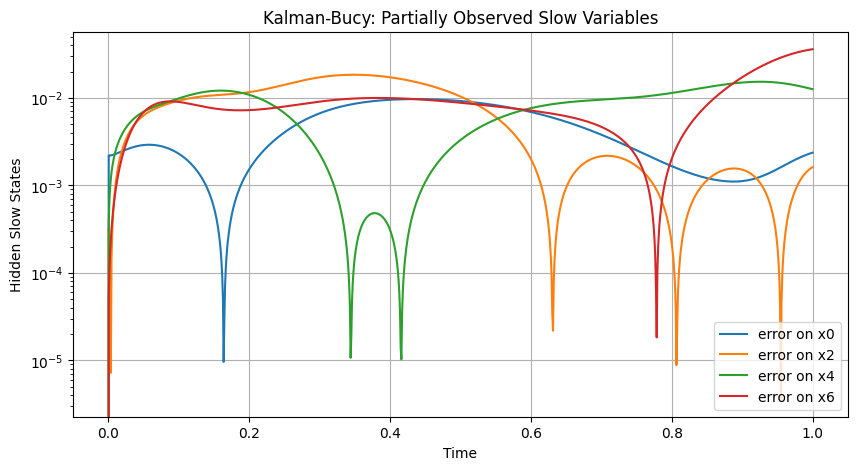

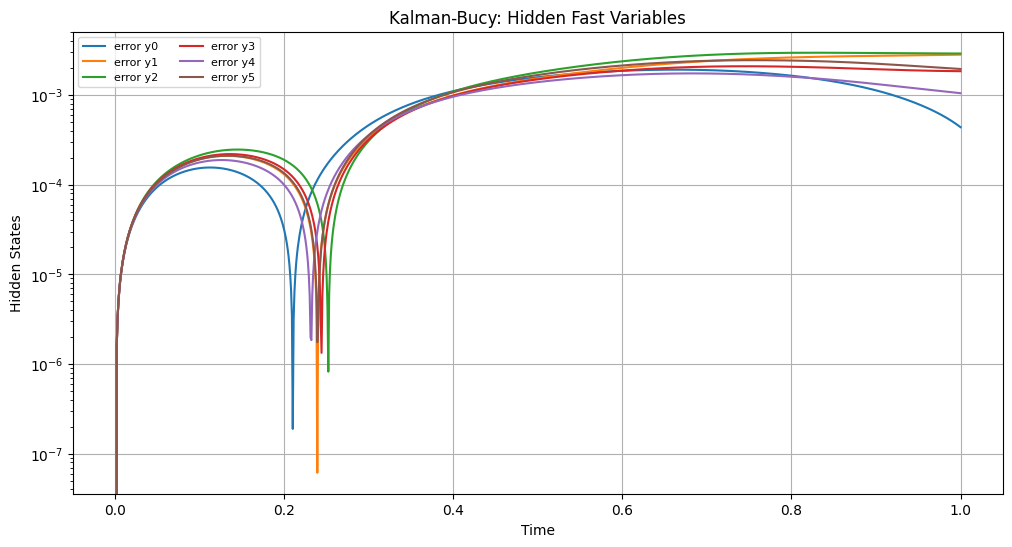

In [25]:
# plot unobserved slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(unobs_id):
    plt.semilogy(t_vals, np.abs(X_traj[:, idx] - uII_est[i]), label=f'error on x{idx}')
    # plt.plot(t_vals, uII_est[i], '--', label=f'Estimated slow x{idx}')
plt.xlabel("Time")
plt.ylabel("Hidden Slow States")
plt.legend()
plt.title("Kalman-Bucy: Partially Observed Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

# plot first few fast variables
num_fast_to_plot = 6
fast_start_idx = len(unobs_id)
for i in range(num_fast_to_plot):
    plt.semilogy(t_vals, np.abs(Y_traj[:, i//J, i%J] - uII_est[fast_start_idx + i]), label=f'error y{i}')
    # plt.plot(t_vals, uII_est[fast_start_idx + i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Kalman-Bucy: Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()

## Random starting point, all slow variables observed

100%|██████████| 999/999 [00:45<00:00, 21.73it/s]


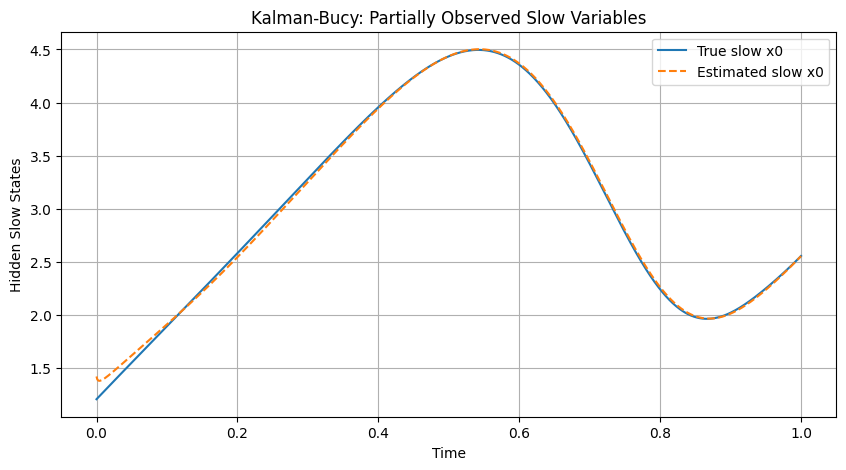

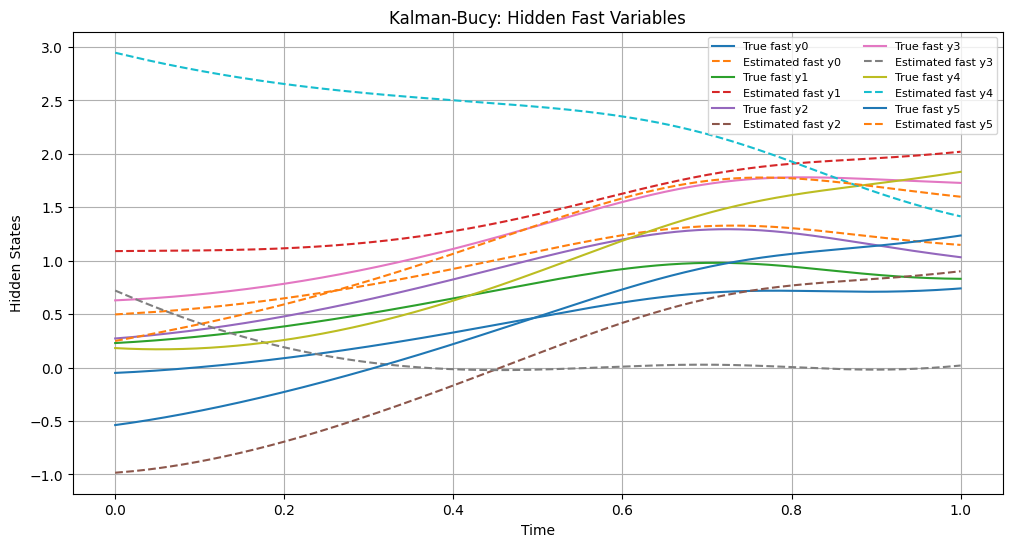

In [ ]:
N = 8
J = 32
F = 8
T = 1
hc = .7
hv = .7
n = 1000
eps = 1
x = np.random.randn(N)  # initial condition
dt = T / (n-1)

# generate true system
X_true = np.random.randn(N)
Y_true = np.random.randn(N,J)
X_traj = np.zeros((n,N))
Y_traj = np.zeros((n,N,J))
X_traj[0] = X_true
Y_traj[0] = Y_true
for i in range(1,n):
    X_traj[i], Y_traj[i] = lorenz96_multiscale(X_traj[i-1], Y_traj[i-1],dt,hc,hv,eps,F)

obs_idx = np.setdiff1d(np.arange(N),unobs_id)  # choose observed slow variables
unobs_id = np.setdiff1d(np.arange(N),obs_idx)  # other slow variables are hidden
hid_idx = np.arange(N*J)  # hide fast variables


uI_obs = X_traj[:, obs_idx] # observed
uII_0 = np.concatenate((X_traj[0,unobs_id],Y_traj[0].flatten()))   # hidden
uII_0 = np.random.randn(len(uII_0))

def f_uI(t, uI, uII, hc = hc, J = J, F=8):
    """Derivative of slow, observed variables."""
    N_unobs = len(unobs_id)
    N = len(uI) + N_unobs
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    slow_vars[unobs_id] = uII[:N_unobs]
    du = np.zeros_like(uI)
    fast_vars = uII[N_unobs:].reshape((N,J))
    for k in range(len(uI)):
        i = obs_idx[k]
        du[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])
    return du

def f_uII(t, uI, uII, hv = hv, J = J, eps = eps, F=8):
    """Derivative of fast, hidden variables and unobserved slow variables."""
    N_unobs = len(unobs_id)
    N = len(uI) + N_unobs
    slow_vars = np.zeros(N)
    slow_vars[obs_idx] = uI
    slow_vars[unobs_id] = uII[:N_unobs]
    dv = np.zeros_like(uII)
    fast_vars = uII[N_unobs:].reshape((N,J))
    for k,i in enumerate(unobs_id):
        dv[k] = (slow_vars[(i+1)%N] - slow_vars[i-2]) * slow_vars[i-1] - slow_vars[i] + F -(hc/J)*np.sum(fast_vars[i])

    for i in range(N):
        for j in range(J):
            dv[N_unobs + (i*J) + j] = (1/eps)*(hv*slow_vars[i] + fast_vars[i,(j+1)%J]*(fast_vars[i,j-1] - fast_vars[i,(j+2)%J]) - fast_vars[i,j])

    return dv.flatten()

t_span = (0, T)
t =  np.linspace(t_span[0], t_span[1], n)

N_unobs = len(unobs_id)
N_fast = len(hid_idx)

R0 = np.zeros((N_unobs + N_fast, N_unobs + N_fast))
# unobserved slow
R0[:N_unobs, :N_unobs] = 1.0*np.eye(N_unobs)
# fast variables
R0[N_unobs:, N_unobs:] = 1.0/J * np.eye(N_fast)


results = kalman_bucy(
    d_uI=lambda t,uI,uII: f_uI(t,uI,uII),
    d_uII=lambda t,uI,uII: f_uII(t,uI,uII),
    t_span=t_span,
    uI=uI_obs,
    uII_0=uII_0,
    R0=R0,
    SigmaI=0.1*np.eye(len(obs_idx)),
    SigmaII=1*np.eye(len(uII_0)),
    dt=dt
)

uII_est = results['uII']

t_vals = results['t']

y_traj = Y_traj.reshape(n,N*J).T


# plot unobserved slow variables
plt.figure(figsize=(10,5))
for i, idx in enumerate(unobs_id):
    plt.plot(t_vals, X_traj[:, idx], label=f'True slow x{idx}')
    plt.plot(t_vals, uII_est[i], '--', label=f'Estimated slow x{idx}')
plt.xlabel("Time")
plt.ylabel("Hidden Slow States")
plt.legend()
plt.title("Kalman-Bucy: Partially Observed Slow Variables")
plt.grid()
plt.show()

plt.figure(figsize=(12,6))

# plot first few fast variables
num_fast_to_plot = 6
fast_start_idx = len(unobs_id)
for i in range(num_fast_to_plot):
    plt.plot(t_vals, Y_traj[:, i//J, i%J], label=f'True fast y{i}')
    plt.plot(t_vals, uII_est[fast_start_idx + i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Kalman-Bucy: Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()




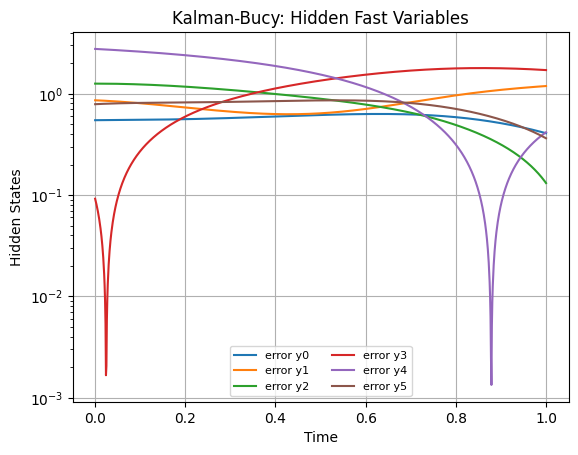

In [39]:
# plot first few fast variables
num_fast_to_plot = 6
fast_start_idx = len(unobs_id)
for i in range(num_fast_to_plot):
    plt.semilogy(t_vals, np.abs(Y_traj[:, i//J, i%J] - uII_est[fast_start_idx + i]), label=f'error y{i}')
    # plt.plot(t_vals, uII_est[fast_start_idx + i], '--', label=f'Estimated fast y{i}')

plt.xlabel("Time")
plt.ylabel("Hidden States")
plt.title("Kalman-Bucy: Hidden Fast Variables")
plt.legend(ncol=2, fontsize=8)
plt.grid()
plt.show()